In [4]:
import matplotlib.pyplot as plt
import numpy as np
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ

import ramsey_experiment

# Loading your IBM Quantum account(s)
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

ibmqfactory.load_account:WARNING:2023-08-20 20:06:18,346: Credentials are already in use. The existing account in the session will be replaced.


In [5]:
h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[(i + 1) % n] - 1) for i in range(n)])


def effective_hem(size, J):
    hem = np.zeros((2 ** size, 2 ** size))
    for i in range(2 ** size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1) ** int(i) for i in binary]
        hem[i, i] = h(size, J, Z)
    return hem

In [6]:
import random
from ramsey_experiment import RamseyExperiment
from ramsey_experiment import RamseyBatch

exp = []
measurements = 128
#shots = np.arange(10, 2000, 100)
shots = [2 ** i for i in range(7, 12)]
delay = np.linspace(0, 2 * np.pi, measurements)
repetitions = 4
for n in range(2, 6):  #qubits
    shot_list = {}
    median_dist_for_shots = []
    mean_dist_for_shots = []
    std_dist_for_shots = []
    for s in shots:
        rep_list = []
        for rep in range(repetitions):
            J = [random.gauss(1, 0.4) for _ in range(n)]
            delay_list = []
            for t in delay:
                delay_list.append(RamseyExperiment(n, t, s // measurements, J,
                                                   f'J = {J} CosineFit n = {n} shots = {s} rep = {rep} delay = {t}'))
            ramseyBatch = RamseyBatch(delay_list)
            rep_list.append(ramseyBatch)

        median_dist_for_shots.append(np.median([rep_list[i].dist for i in range(len(rep_list))]))
        mean_dist_for_shots.append(np.mean([rep_list[i].dist for i in range(len(rep_list))]))
        std_dist_for_shots.append(np.std([rep_list[i].dist for i in range(len(rep_list))]))

        shot_list["mean"] = mean_dist_for_shots
        shot_list["std"] = std_dist_for_shots
        shot_list["median"] = median_dist_for_shots

    exp.append(shot_list)


5
5
5


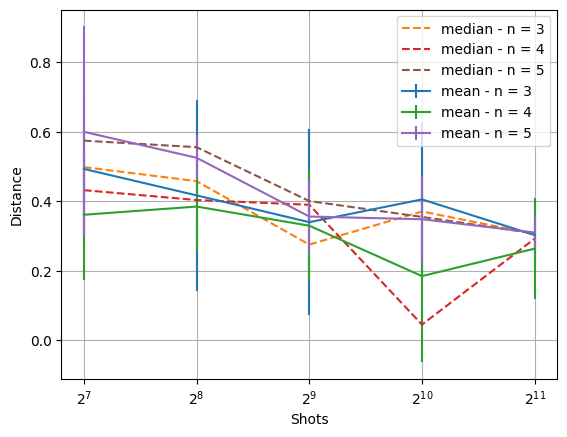

In [7]:
% matplotlib inline

plt.grid()
plt.ylabel('Distance')
plt.xlabel('Shots')
#plt.ylim(0, 0.1)
for i in range(1, len(exp)):
    dist = exp[i]
    print(len(dist["mean"]))
    plt.errorbar(shots, dist["mean"], yerr=dist["std"], linestyle='-', label=f'mean - n = {str(i + 2)}')
    plt.plot(shots, dist["median"], linestyle='--', label=f'median - n = {str(i + 2)}')
plt.xscale('log', base=2)
plt.legend()

## 4 Qubits with Varying Number of Measurement Points

In [9]:
import random
from ramsey_experiment import RamseyExperiment
from ramsey_experiment import RamseyBatch

exp = []
measurements = [2 ** i for i in range(7, 10)]
shots = [2 ** i for i in range(7, 12)]
#shots = [500]
repetitions = 20
for n in measurements:  #qubits
    shot_list = {}
    median_dist_for_shots = []
    mean_dist_for_shots = []
    std_dist_for_shots = []
    for s in shots:
        rep_list = []
        for rep in range(repetitions):
            J = [random.gauss(1, 0.1) for _ in range(4)]
            delay_list = []
            delay = np.linspace(0, 2 * np.pi, n)
            for t in delay:
                delay_list.append(
                    RamseyExperiment(4, t, s // n, J, f'CosineFit meas = {n} shots = {s} rep = {rep} delay = {t}'))
            ramseyBatch = RamseyBatch(delay_list)
            rep_list.append(ramseyBatch)
        median_dist_for_shots.append(np.median([rep_list[i].dist for i in range(len(rep_list))]))
        mean_dist_for_shots.append(np.mean([rep_list[i].dist for i in range(len(rep_list))]))
        std_dist_for_shots.append(np.std([rep_list[i].dist for i in range(len(rep_list))]))

        shot_list["mean"] = mean_dist_for_shots
        shot_list["std"] = std_dist_for_shots
        shot_list["median"] = median_dist_for_shots

    exp.append(shot_list)



QiskitError: 'No counts for experiment "0"'

In [ ]:
plt.grid()
plt.ylabel('Distance')
plt.xlabel('Shots')
#plt.ylim(0, 0.1)
for i in range(1, len(exp)):
    dist = exp[i]
    plt.errorbar(shots, dist["mean"], yerr=dist["std"], linestyle='-',
                 label=f'mean - measurement points = {str(measurements[i])}')
    plt.plot(shots, dist["median"], linestyle='--', label=f'median - measurement points = {str(measurements[i])}')
plt.xscale('log', base=2)
plt.legend()

## 4 Qubits with Varying Number of Measurement Points and fixed number of shots

In [11]:
import random
from ramsey_experiment import RamseyExperiment
from ramsey_experiment import RamseyBatch

exp = []
measurements = [2 ** i for i in range(4, 10)]
shots = 2048
repetitions = 20
shot_list = {}
median_dist_for_shots = []
mean_dist_for_shots = []
std_dist_for_shots = []
for n in measurements:  #qubits

    rep_list = []
    for rep in range(repetitions):
        J = [random.gauss(1, 0.1) for _ in range(4)]
        delay_list = []
        delay = np.linspace(0, 2 * np.pi, n)
        for t in delay:
            delay_list.append(
                RamseyExperiment(4, t, shots // n, J, f'CosineFit meas = {n} shots = {s} rep = {rep} delay = {t}'))
        ramseyBatch = RamseyBatch(delay_list)
        rep_list.append(ramseyBatch)
    median_dist_for_shots.append(np.median([rep_list[i].dist for i in range(len(rep_list))]))
    mean_dist_for_shots.append(np.mean([rep_list[i].dist for i in range(len(rep_list))]))
    std_dist_for_shots.append(np.std([rep_list[i].dist for i in range(len(rep_list))]))

shot_list["mean"] = mean_dist_for_shots
shot_list["std"] = std_dist_for_shots
shot_list["median"] = median_dist_for_shots

exp.append(shot_list)



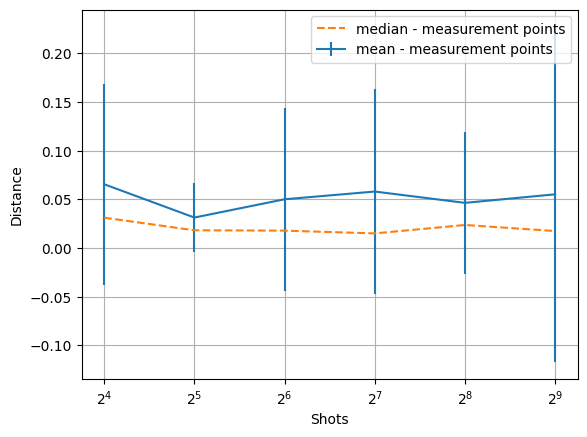

In [12]:
plt.grid()
plt.ylabel('Distance')
plt.xlabel('Shots')
#plt.ylim(0, 0.1)
dist = shot_list
plt.errorbar(measurements, dist["mean"], yerr=dist["std"], linestyle='-', label=f'mean - measurement points')
plt.plot(measurements, dist["median"], linestyle='--', label=f'median - measurement points')

plt.xscale('log', base=2)
plt.legend()

ibmqfactory.load_account:WARNING:2023-08-20 20:50:44,386: Credentials are already in use. The existing account in the session will be replaced.


[1.1427127635933145, 0.6618471551098581, 0.7950166929006339]
[0.82882927 0.7564948  0.63941214]
[0.82882927 0.7564948  0.63941214]


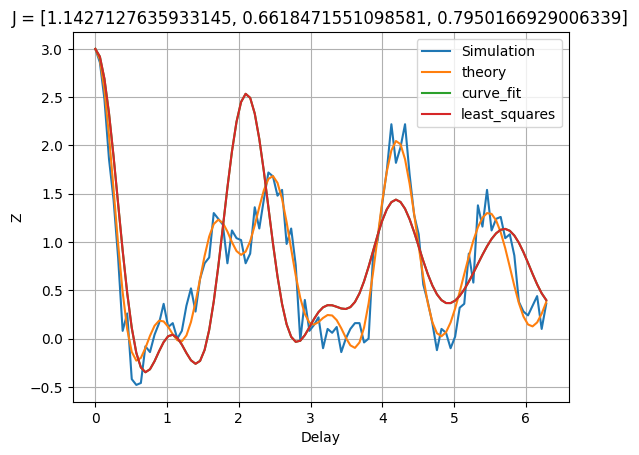

In [37]:
import random
import importlib
import ramsey_experiment

ramsey_experiment = importlib.reload(ramsey_experiment)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

n = 3


def func(t, js):
    n = len(js)
    result = 2 * n
    for i in range(n):
        result += 4 * np.cos(4 * js[i] * t)
    for i in range(n):
        result += 2 * np.cos(4 * (js[i] + js[(i + 1) % n]) * t)
    return result / (2 ** (n - (n - 3)))


#J = [random.gauss(1, 0.3) for _ in range(n)]
J = [1.1427127635933145, 0.6618471551098581, 0.7950166929006339]
delay_list = []
exp = []
measurements = 100
delay = np.linspace(0, 2 * np.pi, measurements)
for t in delay:
    delay_list.append(RamseyExperiment(n, t, 100, J, "3"))
ramseyBatch1 = RamseyBatch("curve_fit", delay_list)
ramseyBatch2 = RamseyBatch("least_squares", delay_list)

print(J)
print(ramseyBatch1.J_fit)
print(ramseyBatch2.J_fit)
#print(ramseyBatch.Z)
plt.grid()
plt.ylabel('Z')
plt.xlabel('Delay')
plt.title(f'J = {J}')
plt.plot(delay, ramseyBatch1.Z, label='Simulation')

plt.plot(delay, [func(t, J) for t in delay], label='theory')
plt.plot(delay, [func(t, ramseyBatch1.J_fit) for t in delay], label='curve_fit')
plt.plot(delay, [func(t, ramseyBatch2.J_fit) for t in delay], label='least_squares')


plt.legend()

[0.7499999999999999, 1.2499999999999998, 1.9999999999999998, 2.7499999999999996, 3.9999999999999996, 6.499999999999999, 4.749999999999999]


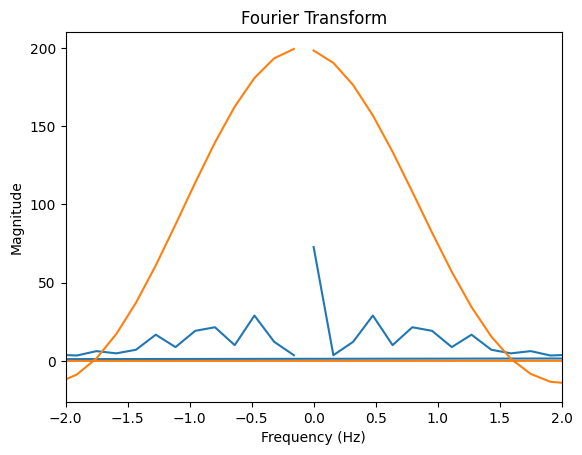

In [50]:
from scipy.signal import find_peaks

def fo(t, js):
    n = len(js)
    result = 0
    for i in range(n):
        result += 40 * np.sinc(t + 2*js[i]/np.pi)
        result += 40 * np.sinc(t - 2*js[i]/np.pi)
    for i in range(n):
        result += 20 * np.sinc(2*js[i]/np.pi + js[(i + 1) % n]/np.pi + t)
        result += 20 * np.sinc(-2*js[i]/np.pi + js[(i + 1) % n]/np.pi + t)
    return result



fft_output = np.fft.fft(ramseyBatch1.Z)
# Compute the corresponding frequencies
sample_rate = measurements / (2 * np.pi)  # Sampling rate of your data (change if known)
frequencies = np.fft.fftfreq(len(ramseyBatch.Z), 1 / sample_rate)

# Compute the magnitude (absolute value) of the Fourier Transform
magnitude = np.abs(fft_output)
peaks, _ = find_peaks(magnitude, height=2)  # Set an appropriate threshold
sorted_peaks = np.argsort(magnitude[peaks])[-14:][::-1]
peak_frequencies = frequencies[peaks[sorted_peaks]]
peak_frequencies = [freq * (0.5*np.pi) for freq in peak_frequencies if freq > 0]

print(peak_frequencies)
# Plot the magnitude of the Fourier Transform
plt.plot(frequencies, magnitude)
plt.plot(frequencies, [fo(t, J) for t in frequencies])

plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(-2, 2)
plt.show()